In [1]:
import pandas as pd

#df=pd.read_csv("FPA_FOD_Plus.csv")
df=pd.read_csv("1992_FPA_FOD_cons.csv")


C:\Users\axjui\AppData\Local\Temp\ipykernel_24024\604886954.py:4: DtypeWarning: Columns (9,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("1992_FPA_FOD_cons.csv")


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
print(df.dtypes.value_counts())
print("-" * 30)


# ANALYSE DES VALEURS MANQUANTES (NaN)
# Calcul du pourcentage de vide par colonne
missing_percent = df.isnull().mean() * 100

# Filtrer pour voir seulement les colonnes qui ont des problèmes
colonnes_vides = missing_percent[missing_percent > 0].sort_values(ascending=False)

print(f"Nombre de colonnes contenant des NaN : {len(colonnes_vides)}")
if not colonnes_vides.empty:
    print("\nTop 10 des colonnes les plus vides (%) :")
    print(colonnes_vides.head(40))

# NETTOYAGE : Supprimer les colonnes > 50% vides
seuil = 50
cols_to_drop_nan = missing_percent[missing_percent > seuil].index
print(f"\n[ACTION] Colonnes à la supprimer (> {seuil}% vide) : {len(cols_to_drop_nan)}")



# DÉTECTION DES COLONNES "INUTILES" (Constantes)
# Une colonne qui a 1 seule valeur unique n'apporte aucune info
nunique = df.nunique()
cols_constantes = nunique[nunique == 1].index

print("-" * 30)
print(f"[ACTION] Colonnes constantes (variance nulle) détectées : {len(cols_constantes)}")
if len(cols_constantes) > 0:
    print(list(cols_constantes))
    




float64    247
object      51
int64       10
Name: count, dtype: int64
------------------------------
Nombre de colonnes contenant des NaN : 195

Top 10 des colonnes les plus vides (%) :
PoaSecunda                       100.000000
Popo_1km                         100.000000
IAULHS_89                        100.000000
IAPLHS_88                        100.000000
IALMIL_87                        100.000000
GACC_Fire Use Teams              100.000000
GACC_Area Command Teams          100.000000
GACC_NIMO Teams                  100.000000
GACC_Type 2 IMTs                 100.000000
GACC_Type 1 IMTs                 100.000000
GACC_Uncont LF                   100.000000
GACC_New LF                      100.000000
GACC_New fire                    100.000000
MOD_NDVI_12m                     100.000000
MOD_EVI_12m                      100.000000
GACC_PL                          100.000000
GACCAbbrev                       100.000000
IAHSEF                           100.000000
Population           

ici on à analyser les valeurs manquantes, on va ensuite supprimer les colonnes avec 50% de valeurs manquantes.
On détecte aussi les colonnes n'ont qu'une seul valeur et qui n'apporte rien pour les supprimers

In [8]:
#verifier tout de même qu'on ne supprime pas des colonnes intéressantes
print(df[cols_constantes].head())

   FIRE_YEAR NWCG_CAUSE_AGE_CATEGORY  IA_LMI_ET  IA_UN_ET  IA_POV_ET  IAULHSE  \
0       1992                     NaN        0.0       0.0        0.0      0.0   
1       1992                     NaN        0.0       0.0        0.0      0.0   
2       1992                   Minor        0.0       0.0        0.0      0.0   
3       1992                     NaN        0.0       0.0        0.0      0.0   
4       1992                     NaN        0.0       0.0        0.0      0.0   

   IAPLHSE  IALMILHSE  IALHE tmmn_Percentile tmmx_Percentile  
0      0.0        0.0    0.0            >90%            >90%  
1      0.0        0.0    0.0            >90%            >90%  
2      0.0        0.0    0.0            >90%            >90%  
3      0.0        0.0    0.0            >90%            >90%  
4      0.0        0.0    0.0            >90%            >90%  


On supprime les colonnes inutiles

In [9]:
## on supprime les colonnes non utiles 
## Supprimer les colonnes > 50% vides
df = df.drop(columns=cols_to_drop_nan,errors='ignore')
## suppression d'une colonne qui a 1 seule valeur unique n'apporte aucune info
df = df.drop(columns=cols_constantes,errors='ignore') 

Nous avons remarqué qu'il y a de nombreuses valeurs suspectes dans notre data set donc nous allons essayé dans un premier temps de les détecter

In [10]:
# On sélectionne uniquement les colonnes numériques pour le scan
df_num = df.select_dtypes(include=[np.number])

print(f"--- SCAN DES VALEURS SUSPECTES (SUR {df_num.shape[1]} COLONNES) ---")

# 1. On calcule les Min et Max de chaque colonne
stats = df_num.agg(['min', 'max']).transpose()

# 2. On définit nos critères de suspicion (basé sur les standards informatiques)
# Critère 1 : Max suspect (proche des limites 16-bit ou valeurs "999...")
suspects_max = stats[
    (stats['max'] > 30000) |       # Type 32767 (SIG/Altitude)
    (stats['max'] == 9999) |       # Code erreur classique
    (stats['max'] == 999)          # Code erreur classique
]

# Critère 2 : Min suspect (valeurs négatives absurdes)
suspects_min = stats[
    (stats['min'] < -900) |        # Type -9999
    (stats['min'] == -1) & (stats['max'] > 1000) # Parfois -1 est utilisé comme "No Data" dans des grands nombres
]

print(f"Colonnes avec des MAX suspects (> 30000 ou 9999) : {len(suspects_max)}")
print(f"Colonnes avec des MIN suspects (< -900)          : {len(suspects_min)}")

if not suspects_max.empty:
    print("\n--- EXEMPLE DE SUSPECTS (MAX) ---")
    print(suspects_max.sort_values(by='max', ascending=False).head(10))

if not suspects_min.empty:
    print("\n--- EXEMPLE DE SUSPECTS (MIN) ---")
    print(suspects_min.sort_values(by='min').head(10))

# --- SUGGESTION D'ACTION ---
# Ce code sert juste à VOIR. Si vous confirmez que ce sont des erreurs,
# la prochaine étape sera de les remplacer globalement par np.nan

--- SCAN DES VALEURS SUSPECTES (SUR 217 COLONNES) ---
Colonnes avec des MAX suspects (> 30000 ou 9999) : 9
Colonnes avec des MIN suspects (< -900)          : 4

--- EXEMPLE DE SUSPECTS (MAX) ---
                 min           max
FOD_ID     42087.000  3.002997e+08
TRACT        100.000  9.989000e+05
FIRE_SIZE      0.010  1.775440e+05
GDP        16425.541  5.148017e+04
TPF            0.000  3.991900e+04
FRG        -9999.000  3.276700e+04
Elevation    -70.000  3.276700e+04
Aspect        -1.000  3.276700e+04
Slope          0.000  3.276700e+04

--- EXEMPLE DE SUSPECTS (MIN) ---
                 min       max
GHM    -3.402823e+38      0.98
SDI    -3.402823e+36      2.88
FRG    -9.999000e+03  32767.00
Aspect -1.000000e+00  32767.00


Ici on remarque donc de nombreuses valeurs aberrantes, dans le code suivant on va essayer de gérer ça pour les colonnes adéquates (on ne touche pas au id par exemple), on va remplacer les valeurs aberrantes par des nan.

In [11]:
# On travaille sur une copie
df_clean = df.copy()

print("--- DÉBUT DU NETTOYAGE DÉTAILLÉ (V2) ---")

# --- 1. ERREURS TECHNIQUES (FLOAT MIN) ---
# inchangé, c'est très bien
print("\n[1] Recherche des valeurs infiniment petites (-3.4e38)...")
cols_float = df_clean.select_dtypes(include=[np.number]).columns
total_float_err = 0

for col in cols_float:
    mask = df_clean[col] < -1e30
    count = mask.sum()
    if count > 0:
        df_clean.loc[mask, col] = np.nan
        print(f"   -> Colonne '{col}' : {count} valeurs techniques remplacées par NaN")
        total_float_err += count

if total_float_err == 0:
    print("   Aucune erreur technique de ce type trouvée.")


# --- 2. CODES D'ERREUR NÉGATIFS (-999, -9999, -99999...) ---
# C'EST ICI LA MODIFICATION IMPORTANTE
print("\n[2] Recherche des codes d'erreur négatifs (< -900)...")

# On exclut Lat/Long car elles peuvent être légitimement négatives (USA ~ -100 Longitude)
cols_to_check = [c for c in df_clean.columns if c not in ['LATITUDE', 'LONGITUDE']]

total_codes_err = 0
for col in cols_to_check:
    # On vérifie si la colonne est numérique
    if pd.api.types.is_numeric_dtype(df_clean[col]):
        
        # AU LIEU DE CHERCHER UNE LISTE PRÉCISE, ON CHERCHE UN SEUIL
        # On considère que toute valeur < -900 est un code d'erreur 
        # (L'altitude la plus basse aux USA est -86m, donc -900 est safe)
        mask = df_clean[col] < -900
        
        count = mask.sum()
        if count > 0:
            df_clean.loc[mask, col] = np.nan
            print(f"   -> Colonne '{col}' : {count} valeurs (< -900) remplacées par NaN")
            total_codes_err += count

if total_codes_err == 0:
    print("   Aucun code d'erreur négatif trouvé.")


# --- 3. ERREUR TOPOGRAPHIQUE (32767) ---
# inchangé, c'est très bien
print("\n[3] Recherche des erreurs '32767' (Topo/FRG)...")
cols_topo = ['FRG', 'Elevation', 'Aspect', 'Slope']
total_topo_err = 0

for col in cols_topo:
    if col in df_clean.columns:
        mask = df_clean[col] >= 32767
        count = mask.sum()
        if count > 0:
            df_clean.loc[mask, col] = np.nan
            print(f"   -> Colonne '{col}' : {count} valeurs '32767' remplacées par NaN")
            total_topo_err += count

print("\n--- NETTOYAGE TERMINÉ ---")
print(f"Total des cellules corrigées : {total_float_err + total_codes_err + total_topo_err}")

--- DÉBUT DU NETTOYAGE DÉTAILLÉ (V2) ---

[1] Recherche des valeurs infiniment petites (-3.4e38)...
   -> Colonne 'GHM' : 145 valeurs techniques remplacées par NaN
   -> Colonne 'SDI' : 22 valeurs techniques remplacées par NaN

[2] Recherche des codes d'erreur négatifs (< -900)...
   -> Colonne 'FRG' : 31 valeurs (< -900) remplacées par NaN

[3] Recherche des erreurs '32767' (Topo/FRG)...
   -> Colonne 'FRG' : 530 valeurs '32767' remplacées par NaN
   -> Colonne 'Elevation' : 561 valeurs '32767' remplacées par NaN
   -> Colonne 'Aspect' : 561 valeurs '32767' remplacées par NaN
   -> Colonne 'Slope' : 561 valeurs '32767' remplacées par NaN

--- NETTOYAGE TERMINÉ ---
Total des cellules corrigées : 2411


Maintenant que nous avons remplacé toutes les valeurs aberrantes par des Nan, nous allons analysé les Nan en question

Nombre de colonnes contenant des NaN : 234 sur 265

--- TOP 20 DES COLONNES LES PLUS VIDES (%) ---
FIRE_NAME                43.230659
CONT_TIME                42.977762
CONT_DATE                38.854021
CONT_DOY                 38.854021
road_common_name_dis     35.504041
No_FireStation_5.0km     34.623615
DISCOVERY_TIME           34.222185
LOCAL_INCIDENT_ID        32.330215
FIPS_NAME                28.915219
COUNTY                   28.915176
FIPS_CODE                28.915176
WF_PFS                   27.321227
Population               26.046147
Popo_1km                 25.819743
MOD_NDVI_12m             25.064961
MOD_EVI_12m              25.064961
EPL_DISABL               15.043164
TF_PFS                   11.222873
No_FireStation_10.0km     8.694514
LLEF_PFS                  8.570823
dtype: float64


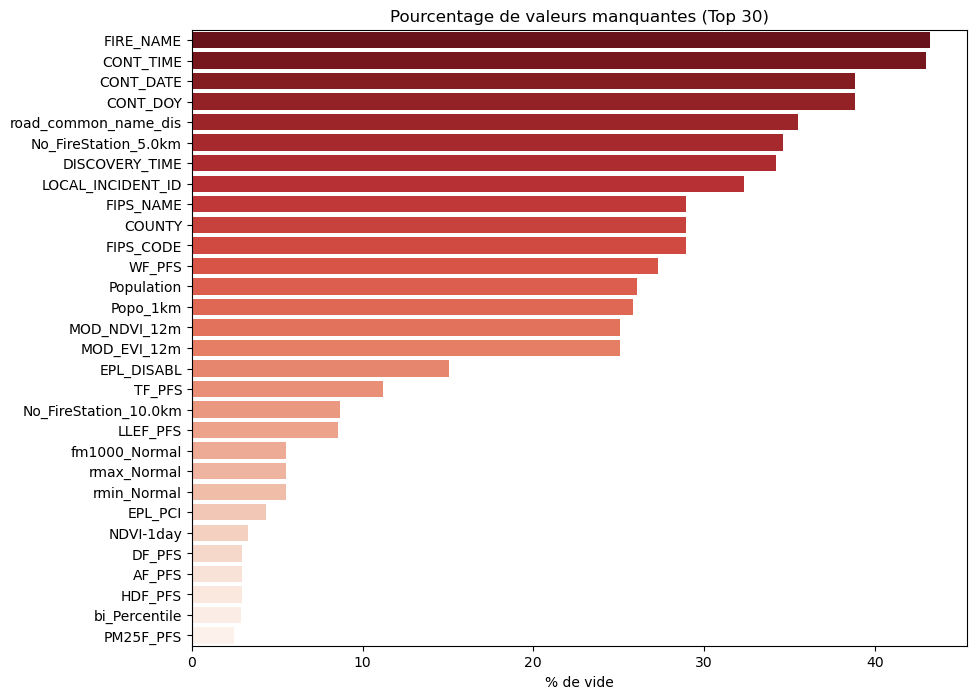

In [7]:
# Calcul du pourcentage de vide pour chaque colonne
nan_stats = df_clean.isnull().mean() * 100

# On ne garde que les colonnes qui ont des NaN
cols_with_nan = nan_stats[nan_stats > 0].sort_values(ascending=False)

print(f"Nombre de colonnes contenant des NaN : {len(cols_with_nan)} sur {len(df_clean.columns)}")

if not cols_with_nan.empty:
    # Affichage du Top 20 des colonnes les plus vides
    print("\n--- TOP 20 DES COLONNES LES PLUS VIDES (%) ---")
    print(cols_with_nan.head(20))

    # Visualisation graphique
    plt.figure(figsize=(10, 8))
    sns.barplot(x=cols_with_nan.head(30).values, y=cols_with_nan.head(30).index, palette="Reds_r")
    plt.title("Pourcentage de valeurs manquantes (Top 30)")
    plt.xlabel("% de vide")
    plt.show()
else:
    print("Bravo ! Aucune valeur manquante détectée (ou tout a été nettoyé).")

On supprime les valeurs manquantes et on remplace quand on peut remplacer par des nan

In [8]:
from sklearn.impute import SimpleImputer

# On travaille toujours sur df_clean
print(f"Dimensions avant traitement des NaN : {df_clean.shape}")

# --- ÉTAPE 1 : SUPPRESSION DES COLONNES "FUITE" ET "INUTILES" ---
# Liste des colonnes à supprimer manuellement
cols_a_bannir = [
    # Fuite de données (Le futur)
    'CONT_DATE', 'CONT_TIME', 'CONT_DOY',
    # Identifiants et Textes inutiles pour le modèle
    'FIRE_NAME', 'LOCAL_INCIDENT_ID', 
    'FIPS_NAME', 'FIPS_CODE', 'COUNTY', # On a déjà Latitude/Longitude
    'DISCOVERY_TIME' # Souvent difficile à utiliser tel quel (format heure)
]

# On ne supprime que celles qui existent encore dans le dataframe
cols_a_supprimer = [c for c in cols_a_bannir if c in df_clean.columns]

df_clean = df_clean.drop(columns=cols_a_supprimer)
print(f"-> Colonnes supprimées (Leakage/IDs) : {len(cols_a_supprimer)}")


# --- ÉTAPE 2 : IMPUTATION (REMPLISSAGE) DES COLONNES RESTANTES ---
# On va remplir TOUTES les colonnes numériques restantes qui ont des trous avec la MÉDIANE

# 1. Identifier les colonnes numériques
cols_num = df_clean.select_dtypes(include=[np.number]).columns

# 2. Créer l'imputeur (L'outil de remplissage)
# Strategy='median' est robuste. Pour plus de précision plus tard, on pourra utiliser KNNImputer.
imputer = SimpleImputer(strategy='median')

# 3. Appliquer le remplissage
# Attention : cela renvoie un tableau numpy, on doit le remettre en DataFrame
print("-> Remplissage des valeurs manquantes par la médiane...")
df_clean[cols_num] = imputer.fit_transform(df_clean[cols_num])


# --- ÉTAPE 3 : VERIFICATION FINAL ---
restant = df_clean.isnull().sum().sum()
print("-" * 30)
print(f"Nombre total de NaN restants : {restant}")
print(f"Dimensions finales du dataset : {df_clean.shape}")

# Petit check visuel sur une colonne qui était vide (ex: Population)
if 'Population' in df_clean.columns:
    print(f"Exemple Population (vérif): Min={df_clean['Population'].min()}, Max={df_clean['Population'].max()}")

Dimensions avant traitement des NaN : (2302521, 265)
-> Colonnes supprimées (Leakage/IDs) : 9
-> Remplissage des valeurs manquantes par la médiane...
------------------------------
Nombre total de NaN restants : 1993084
Dimensions finales du dataset : (2302521, 256)
Exemple Population (vérif): Min=0.0, Max=2229.919


In [9]:


#Matrice de corrélation ciblée et lisible

# Sélection des colonnes numériques uniquement dans votre dataset nettoyé
df_num = df_clean.select_dtypes(include=[np.number])

# Calcul des corrélations de toutes les variables avec FIRE_SIZE
# On trie par valeur absolue pour voir les liens les plus forts en premier
corr_target = df_num.corrwith(df_clean['FIRE_SIZE']).sort_values(ascending=False)

# On retire la ligne FIRE_SIZE vs FIRE_SIZE (qui vaut 1.0)
corr_target = corr_target.drop('FIRE_SIZE', errors='ignore')

# Affichage par blocs de 20 colonnes
chunk_size = 20
print(f"\n--- CORRÉLATIONS AVEC FIRE_SIZE ({len(corr_target)} variables) ---")

for i in range(0, len(corr_target), chunk_size):
    subset = corr_target.iloc[i : i + chunk_size]
    print(f"\n[Variables {i+1} à {min(i+chunk_size, len(corr_target))}]")
    print(subset)


--- CORRÉLATIONS AVEC FIRE_SIZE (216 variables) ---

[Variables 1 à 20]
LATITUDE                0.035734
bi_5D_max               0.029426
erc_5D_mean             0.028792
bi_5D_mean              0.028056
erc_5D_max              0.028012
erc                     0.027592
etr                     0.023823
erc_Normal              0.023166
bi_Normal               0.023113
etr_5D_max              0.022747
etr_5D_mean             0.022707
vpd                     0.022693
vpd_5D_mean             0.022290
bi                      0.021936
vpd_5D_max              0.021884
road_common_name_dis    0.021024
Elevation               0.019170
TRI_1km                 0.018736
NPL                     0.017948
GAP_Prity               0.017830
dtype: float64

[Variables 21 à 40]
Elevation_1km    0.016956
vpd_Normal       0.016949
EVH              0.016687
Slope_1km        0.016354
TRI              0.015585
srad_Normal      0.015357
Slope            0.015178
EVC              0.015110
SDI              0.0146

on a ici les columns avec les correlation maximal 

C:\Users\axjui\AppData\Local\Temp\ipykernel_26444\1327911910.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['log_FIRE_SIZE'] = np.log1p(df_clean['FIRE_SIZE'])


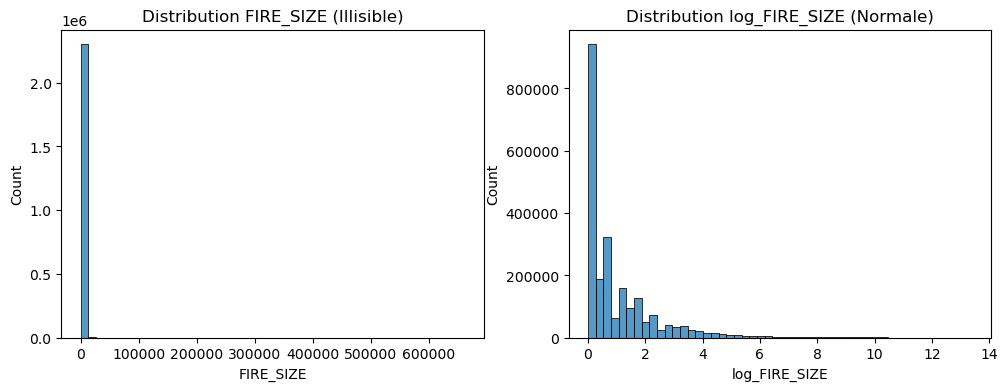

--- CORRÉLATIONS AVEC log_FIRE_SIZE (Top 10) ---
FIRE_SIZE            0.193301
EVC                  0.176732
EBLR_PFS             0.168100
EVH                  0.165799
EPLR_PFS             0.164933
EPL_MOBILE           0.158013
DF_PFS               0.152196
Annual_tempreture    0.142992
HDF_PFS              0.136090
Land_Cover           0.136089
dtype: float64


In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['FIRE_SIZE'], bins=50)
plt.title("Distribution FIRE_SIZE (Illisible)")

# 2. La Solution : Log Transformation
# On utilise log1p (log(1+x)) pour éviter les erreurs si taille=0
df_clean['log_FIRE_SIZE'] = np.log1p(df_clean['FIRE_SIZE'])

plt.subplot(1, 2, 2)
sns.histplot(df_clean['log_FIRE_SIZE'], bins=50)
plt.title("Distribution log_FIRE_SIZE (Normale)")
plt.show()

# 3. Recalculer les corrélations avec cette nouvelle target
corr_new = df_num.corrwith(df_clean['log_FIRE_SIZE']).sort_values(ascending=False)

print("--- CORRÉLATIONS AVEC log_FIRE_SIZE (Top 10) ---")
print(corr_new.head(10))

On test un premier modèle uniquement avec les valeurs numériques

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- ÉTAPE 1 : PRÉPARATION DES DONNÉES ---
# On sélectionne uniquement les colonnes numériques
df_model = df_clean.select_dtypes(include=[np.number]).copy()

# On définit X (features) et y (target)
# Attention : On retire la target de X !
X = df_model.drop(columns=['FIRE_SIZE', 'log_FIRE_SIZE'], errors='ignore')

# On transforme la target avec log1p (log(1+x)) pour gérer les zéros éventuels et lisser la courbe
y_log = np.log1p(df_clean['FIRE_SIZE'])

# --- ÉTAPE 2 : SPLIT TRAIN / TEST ---
# On garde 20% des données pour tester la qualité du modèle à la fin
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# --- ÉTAPE 3 : STANDARDISATION (Optionnelle pour Random Forest, mais bonne pratique) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- ÉTAPE 4 : ENTRAÎNEMENT DU MODÈLE ---
print("Entraînement du Random Forest en cours... (cela peut prendre quelques secondes)")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 utilise tous les coeurs du processeur
model.fit(X_train_scaled, y_train_log)

# --- ÉTAPE 5 : ÉVALUATION ET INVERSION DU LOG ---
# Prédictions (elles sont en échelle logarithmique !)
preds_log = model.predict(X_test_scaled)

# Pour évaluer la performance réelle, on remet tout à l'échelle originale (inverse du log)
# np.expm1 est l'inverse de np.log1p
y_test_original = np.expm1(y_test_log)
preds_original = np.expm1(preds_log)

# Calcul des scores
mae = mean_absolute_error(y_test_original, preds_original)
rmse = np.sqrt(mean_squared_error(y_test_original, preds_original))

print("-" * 30)
print(f"Erreur Moyenne Absolue (MAE) : {mae:.2f}")
print(f"Racine de l'Erreur Quadratique Moyenne (RMSE) : {rmse:.2f}")
print("-" * 30)

# Exemple de comparaison sur les 5 premiers feux du test
print("\nComparaison Réel vs Prédit (5 premiers exemples) :")
comparison = pd.DataFrame({'Réel': y_test_original, 'Prédit': preds_original})
print(comparison.head(5))

Entraînement du Random Forest en cours... (cela peut prendre quelques secondes)


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- ÉTAPE 1 : PRÉPARATION DES DONNÉES ---
# On sélectionne uniquement les colonnes numériques
df_model = df_clean.select_dtypes(include=[np.number]).copy()

# On définit X (features) et y (target)
# Attention : On retire la target de X !
X = df_model.drop(columns=['FIRE_SIZE', 'log_FIRE_SIZE'], errors='ignore')

# On transforme la target avec log1p (log(1+x)) pour gérer les zéros éventuels et lisser la courbe
y_log = np.log1p(df_clean['FIRE_SIZE'])

# --- ÉTAPE 2 : SPLIT TRAIN / TEST ---
# On garde 20% des données pour tester la qualité du modèle à la fin
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# --- ÉTAPE 3 : STANDARDISATION (Optionnelle pour Random Forest, mais bonne pratique) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NameError: name 'df_clean' is not defined

In [ ]:
# Vous aurez peut-être besoin d'installer xgboost :
# !pip install xgboost

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# --- On reprend les mêmes données X_train, X_test, y_train_log, y_test_log ---
# Note : XGBoost n'a PAS besoin de StandardScaler, mais ça ne lui fait pas de mal si c'est déjà fait.

print("Entraînement du XGBoost...")
# Configuration de base performante
model_xgb = XGBRegressor(
    n_estimators=1000,     # Nombre d'arbres (peut être élevé avec early_stopping)
    learning_rate=0.05,    # Vitesse d'apprentissage (plus c'est bas, plus c'est précis mais lent)
    max_depth=6,           # Profondeur des arbres
    n_jobs=-1,             # Utiliser tous les processeurs
    random_state=42
)

# Entraînement avec "Early Stopping"
# Cela arrête l'entraînement si le modèle ne s'améliore plus sur le set de test
# pour éviter le sur-apprentissage (overfitting).
model_xgb.fit(
    X_train, y_train_log,
    eval_set=[(X_test, y_test_log)],
    early_stopping_rounds=50,
    verbose=100  # Affiche le score toutes les 100 étapes
)

# --- ÉVALUATION ---
preds_log_xgb = model_xgb.predict(X_test)

# Inversion du log pour revenir en hectares/acres
y_test_original = np.expm1(y_test_log)
preds_original_xgb = np.expm1(preds_log_xgb)

mae_xgb = mean_absolute_error(y_test_original, preds_original_xgb)
print(f"\nMAE XGBoost : {mae_xgb:.2f}")

# Comparaison rapide
print("\nComparaison Réel vs Prédit (5 premiers) :")
comparison = pd.DataFrame({'Réel': y_test_original, 'XGBoost': preds_original_xgb})
print(comparison.head(5))